In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
import ndlib.models.epidemics.SIModel as si
import ndlib.models.ModelConfig as mc

In [3]:
net = pd.read_excel('assoc_eng2.xlsx') 
net.head()

,source,target,weight
0,a,alphabet,0.066
1,a,apple,0.013
2,a,grade,0.059
3,a,great,0.013
4,a,letter,0.039


In [4]:
source = np.unique(net.source) 
target = np.unique(net.target)
c = np.concatenate((np.array(source), np.array(target)))
common_nodes = np.unique(c)
dict_nodes = {}
counter_nodes = 0

for i in range(len(common_nodes)):
    dict_nodes[common_nodes[i]] = counter_nodes
    counter_nodes += 1



source_l = []; target_l = []
for i in range(len(net)):
    source_l.append(dict_nodes[net['source'][i]])
    target_l.append(dict_nodes[net['target'][i]])   

In [5]:
new_net = pd.DataFrame (np.array([target_l, source_l]).T, 
                        columns = ['t', 's'])
new_net

,t,s
0,116,0
1,175,0
2,1932,0
3,1957,0
4,2503,0
...,...,...
63624,2327,5018
63625,2877,5018
63626,4174,5018
63627,4771,5018


In [6]:
invert_graph = nx.from_pandas_edgelist(new_net, 't', 's', create_using=nx.DiGraph()) 

In [7]:
in_degr = [i for node, i in invert_graph.in_degree()]
mean_in_degree = np.mean(in_degr)
max_in_degree = max(in_degr)
min_in_degree = min(in_degr)  

#out_degr = [i for node, i in graph.out_degree()]
#max_out_degree = max(out_degr)
#mean_out_degree = np.mean(out_degr)
#min_out_degree = min(out_degr)  

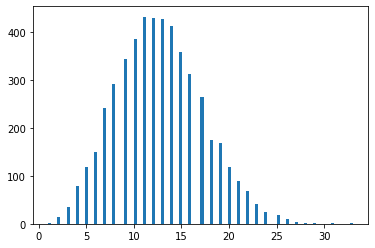

In [14]:
plt.hist(in_degr, bins = 100)
plt.title('in')
plt.savefig('in_degr.png')

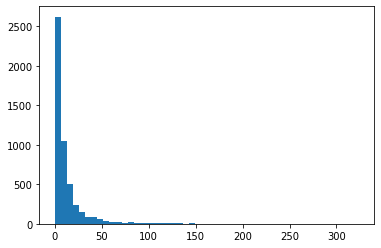

In [15]:
out_degr = [i for node, i in invert_graph.out_degree()]
plt.hist(out_degr, bins = 50)
plt.savefig('out_degr.png')

In [14]:
print('Mean degree: ', mean_in_degree)
print('Max degree: ', max_in_degree )
print('Min degree: ', min_in_degree)

Mean degree:  12.67762502490536
Max degree:  33
Min degree:  1


In [15]:
# неинвертирвоанный граф
init_net = pd.DataFrame (np.array([source_l, target_l]).T, 
                        columns = ['s', 't'])
graph = nx.from_pandas_edgelist(init_net, 's', 't', create_using = nx.DiGraph())

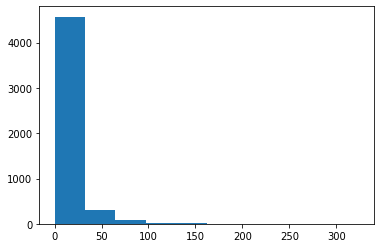

In [16]:
nin_degr = [i for node, i in graph.in_degree()]
nmean_in_degree = np.mean(nin_degr)
nmax_in_degree = max(nin_degr)
nmin_in_degree = min(nin_degr)  

plt.hist(nin_degr)
plt.show()

In [17]:
print('Mean degree: ', nmean_in_degree)
print('Max degree: ', nmax_in_degree )
print('Min degree: ', nmin_in_degree)

Mean degree:  12.67762502490536
Max degree:  324
Min degree:  0


SIR model

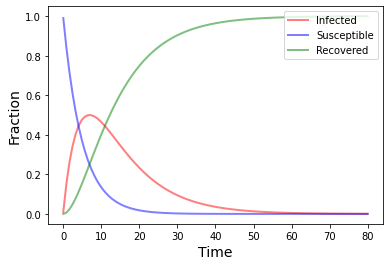

In [18]:
from scipy.integrate import odeint
# The SIR model differential equations.
def deriv(s0, t, beta_k, mu):
    x, y, z = s0 #
    dxdt = beta_k * (1-x-z)- mu* x
    dydt = -beta_k * (1-x-z)
    dzdt = mu * x
    return dxdt, dydt, dzdt


beta_k, mu = 0.2, 1./10 # model parameters
s0 = 0.01, 0.99, 0
t=np.linspace(0,80,100)

ret = odeint(deriv, s0, t, args=( beta_k, mu))
x, y, z = ret.T

plt.plot(t, x, 'r', alpha=0.5, lw=2, label='Infected')
plt.plot(t, y, 'b', alpha=0.5, lw=2, label='Susceptible')
plt.plot(t, z, 'g', alpha=0.5, lw=2, label='Recovered')
plt.xlabel('Time',fontsize=14)
plt.ylabel('Fraction',fontsize=14)
plt.legend(loc='upper right')

In [19]:
N=5019

import ndlib.models.epidemics as sir

sir_model = sir.SIRModel(graph)


config = mc.Configuration()
config.add_model_parameter('beta', 0.005)
config.add_model_parameter('gamma',0.003)
config.add_model_parameter("percentage_infected", 0.05)
sir_model.set_initial_status(config)

iterations = sir_model.iteration_bunch(1000)
susceptible,infected,recovered = [],[],[]
 
for iteration in iterations:
    node_count = iteration['node_count']
    susceptible.append(node_count[0]/N)
    infected.append(node_count[1]/N)
    recovered.append(node_count[2]/N)

100%|██████████| 1000/1000 [00:26<00:00, 37.36it/s]


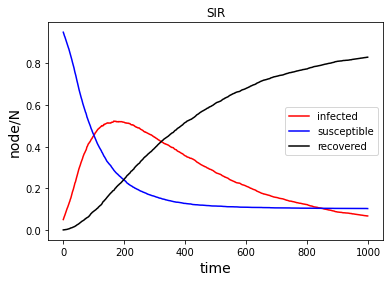

In [20]:
plt.figure(figsize = (6,4))
plt.title('SIR')
plt.plot(infected,color='r',label='infected')
plt.plot(susceptible, color='b',label='susceptible')
plt.plot(recovered, color='k',label='recovered')
plt.xlabel('time', fontsize = 14)
plt.ylabel('node/N', fontsize = 14)
plt.legend()
#plt.savefig('SIR.png')

100%|██████████| 700/700 [00:18<00:00, 38.07it/s]


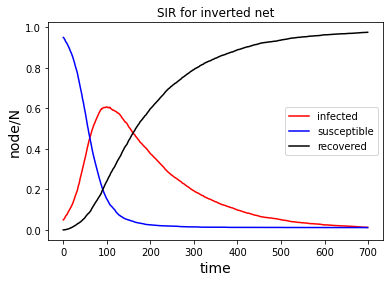

100%|██████████| 700/700 [00:19<00:00, 35.28it/s]


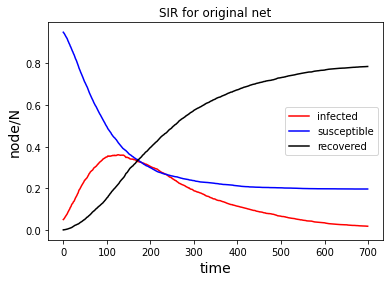

In [21]:
sir_model = sir.SIRModel(invert_graph)


config = mc.Configuration()
config.add_model_parameter('beta', 0.005)
config.add_model_parameter('gamma',0.007)
config.add_model_parameter("percentage_infected", 0.05)
sir_model.set_initial_status(config)

iterations = sir_model.iteration_bunch(700)
susceptible,infected,recovered = [],[],[]
 
for iteration in iterations:
    node_count = iteration['node_count']
    susceptible.append(node_count[0]/N)
    infected.append(node_count[1]/N)
    recovered.append(node_count[2]/N)

plt.figure(figsize = (6,4))
plt.title('SIR for inverted net')
plt.plot(infected,color='r',label='infected')
plt.plot(susceptible, color='b',label='susceptible')
plt.plot(recovered, color='k',label='recovered')
plt.xlabel('time', fontsize = 14)
plt.ylabel('node/N', fontsize = 14)
plt.legend()
plt.show()

###########################

sir_model = sir.SIRModel(graph)

config = mc.Configuration()
config.add_model_parameter('beta', 0.005)
config.add_model_parameter('gamma',0.007)
config.add_model_parameter("percentage_infected", 0.05)
sir_model.set_initial_status(config)

iterations = sir_model.iteration_bunch(700)
susceptible,infected,recovered = [],[],[]
 
for iteration in iterations:
    node_count = iteration['node_count']
    susceptible.append(node_count[0]/N)
    infected.append(node_count[1]/N)
    recovered.append(node_count[2]/N)

plt.figure(figsize = (6,4))
plt.title('SIR for original net')
plt.plot(infected,color='r',label='infected')
plt.plot(susceptible, color='b',label='susceptible')
plt.plot(recovered, color='k',label='recovered')
plt.xlabel('time', fontsize = 14)
plt.ylabel('node/N', fontsize = 14)
plt.legend()
plt.show()

In [22]:
print('epidemic coefficient:', 0.005*mean_in_degree/0.007)

epidemic coefficient: 9.055446446360973


100%|██████████| 1000/1000 [00:31<00:00, 32.21it/s]


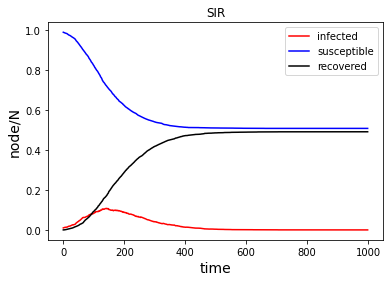

In [23]:
sir_model = sir.SIRModel(graph)

config = mc.Configuration()
config.add_model_parameter('beta', 0.005)
config.add_model_parameter('gamma',0.02)
config.add_model_parameter("percentage_infected", 0.01)
sir_model.set_initial_status(config)

iterations = sir_model.iteration_bunch(1000)
susceptible,infected,recovered = [],[],[]
 
for iteration in iterations:
    node_count = iteration['node_count']
    susceptible.append(node_count[0]/N)
    infected.append(node_count[1]/N)
    recovered.append(node_count[2]/N)

plt.figure(figsize = (6,4))
plt.title('SIR')
plt.plot(infected,color='r',label='infected')
plt.plot(susceptible, color='b',label='susceptible')
plt.plot(recovered, color='k',label='recovered')
plt.xlabel('time', fontsize = 14)
plt.ylabel('node/N', fontsize = 14)
plt.legend()

### Исследование транзитивности

(число троек в графе)

In [24]:
nx.transitivity(invert_graph) == nx.transitivity(graph)

False

In [25]:
nx.transitivity(invert_graph), nx.transitivity(graph)

(0.03549719211963905, 0.1228734955845273)

### Randomization - degree preserving randomization. 
(Make permutations preserving nodes' degree)

Show wheather variations in the given net are an artifact of graph's inherent structure or nodes properties.

nodes' degree is the same but the graph's structure is changed


In [26]:
!pip install xswap
import xswap 

     |████████████████████████████████| 481kB 2.7MB/s 


In [ ]:
#invert_graph.edges

In [7]:
# транзитивность для инвертирвоанного
rand_edges = xswap.permute_edge_list(list(invert_graph.edges), allow_self_loops=False, allow_antiparallel=False, multiplier = 10)
rand_invert_graph = nx.from_edgelist(rand_edges[0], create_using=nx.DiGraph())

NameError: ignored

In [ ]:
nx.transitivity(rand_invert_graph)

In [ ]:
print('Delta:', nx.transitivity(rand_invert_graph) - nx.transitivity(invert_graph))

Delta: -0.03256989397213818


In [ ]:
# инвертированный граф

sir_model = sir.SIRModel(invert_graph)


config = mc.Configuration()
config.add_model_parameter('beta', 0.005)
config.add_model_parameter('gamma',0.007)
config.add_model_parameter("percentage_infected", 0.05)
sir_model.set_initial_status(config)

iterations = sir_model.iteration_bunch(700)
susceptible1,infected1,recovered1 = [],[],[]
 
for iteration in iterations:
    node_count = iteration['node_count']
    susceptible1.append(node_count[0]/N)
    infected1.append(node_count[1]/N)
    recovered1.append(node_count[2]/N)


# рандомизированный инвертированный граф

sir_model = sir.SIRModel(rand_invert_graph)


config = mc.Configuration()
config.add_model_parameter('beta', 0.005)
config.add_model_parameter('gamma',0.007)
config.add_model_parameter("percentage_infected", 0.05)
sir_model.set_initial_status(config)

iterations = sir_model.iteration_bunch(700)
susceptible2,infected2,recovered2 = [],[],[]
 
for iteration in iterations:
    node_count = iteration['node_count']
    susceptible2.append(node_count[0]/N)
    infected2.append(node_count[1]/N)
    recovered2.append(node_count[2]/N)


100%|██████████| 700/700 [00:18<00:00, 37.29it/s]

100%|██████████| 700/700 [00:18<00:00, 38.39it/s]


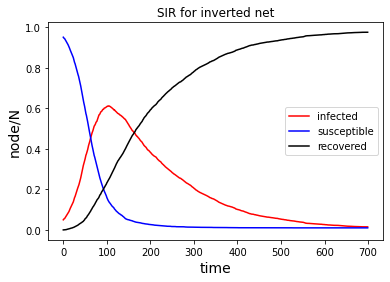

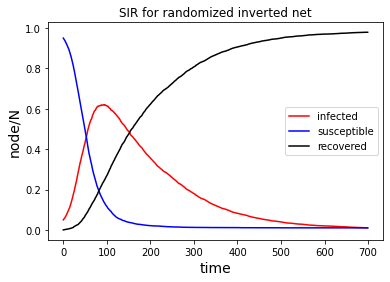

In [ ]:
plt.figure(figsize = (6,4))
plt.title('SIR for inverted net')
plt.plot(infected1,color='r',label='infected')
plt.plot(susceptible1, color='b',label='susceptible')
plt.plot(recovered1, color='k',label='recovered')
plt.xlabel('time', fontsize = 14)
plt.ylabel('node/N', fontsize = 14)
plt.legend()
plt.show()


plt.figure(figsize = (6,4))
plt.title('SIR for randomized inverted net')
plt.plot(infected2,color='r',label='infected')
plt.plot(susceptible2, color='b',label='susceptible')
plt.plot(recovered2, color='k',label='recovered')
plt.xlabel('time', fontsize = 14)
plt.ylabel('node/N', fontsize = 14)
plt.legend()
plt.show()

In [ ]:
# транзитивность для неинвертирвоанного

rand_edges_init = xswap.permute_edge_list(list(graph.edges), allow_self_loops=False, allow_antiparallel=False)
rand_graph_init = nx.from_edgelist(rand_edges_init[0], create_using=nx.DiGraph())

In [ ]:
nx.transitivity(rand_graph_init)

0.00990038183811576

In [ ]:
print('Delta:', nx.transitivity(rand_graph_init) - nx.transitivity(graph))

Delta: -0.11297311374641154


In [ ]:
# инвертированный граф

sir_model = sir.SIRModel(graph)


config = mc.Configuration()
config.add_model_parameter('beta', 0.005)
config.add_model_parameter('gamma',0.007)
config.add_model_parameter("percentage_infected", 0.05)
sir_model.set_initial_status(config)

iterations = sir_model.iteration_bunch(700)
susceptible1,infected1,recovered1 = [],[],[]
 
for iteration in iterations:
    node_count = iteration['node_count']
    susceptible1.append(node_count[0]/N)
    infected1.append(node_count[1]/N)
    recovered1.append(node_count[2]/N)


# рандомизированный инвертированный граф

sir_model = sir.SIRModel(rand_graph_init)


config = mc.Configuration()
config.add_model_parameter('beta', 0.005)
config.add_model_parameter('gamma',0.007)
config.add_model_parameter("percentage_infected", 0.05)
sir_model.set_initial_status(config)

iterations = sir_model.iteration_bunch(700)
susceptible2,infected2,recovered2 = [],[],[]
 
for iteration in iterations:
    node_count = iteration['node_count']
    susceptible2.append(node_count[0]/N)
    infected2.append(node_count[1]/N)
    recovered2.append(node_count[2]/N)


100%|██████████| 700/700 [00:18<00:00, 37.06it/s]

100%|██████████| 700/700 [00:19<00:00, 36.78it/s]


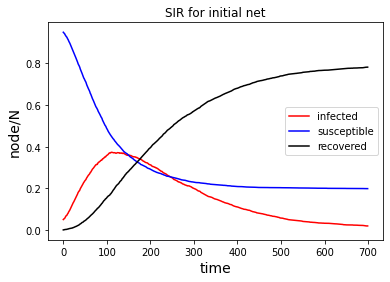

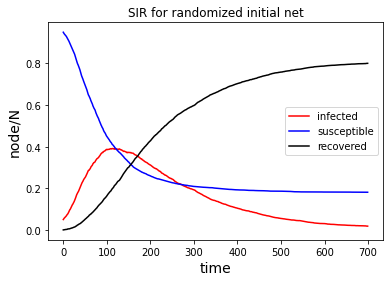

In [ ]:

plt.figure(figsize = (6,4))
plt.title('SIR for initial net')
plt.plot(infected1,color='r',label='infected')
plt.plot(susceptible1, color='b',label='susceptible')
plt.plot(recovered1, color='k',label='recovered')
plt.xlabel('time', fontsize = 14)
plt.ylabel('node/N', fontsize = 14)
plt.legend()
plt.show()

plt.figure(figsize = (6,4))
plt.title('SIR for randomized initial net')
plt.plot(infected2,color='r',label='infected')
plt.plot(susceptible2, color='b',label='susceptible')
plt.plot(recovered2, color='k',label='recovered')
plt.xlabel('time', fontsize = 14)
plt.ylabel('node/N', fontsize = 14)
plt.legend()
plt.show()

In [ ]:
edges_list = list(graph.edges())
count = 0
bidirectional = []
for ed in edges_list:
    ied = (ed[1],ed[0])
    if ied in edges_list:
        count += 1
        bidirectional.append(ied)
        edges_list.remove(ied)

print('Bidirectional edges:', count)  
 
import itertools
import random
import networkx
 
random.seed(42)
"""An interaction graph which can produce a "random" graph from
    itself by an iterative edge-swap technique that preserves the degree
    distribution of the original graph.
    """
def randomize_by_edge_swaps(graph, num_iterations):
        """Randomizes the graph by swapping edges in such a way that
        preserves the degree distribution of the original graph.
        The underlying idea stems from the following. We have this
        original formation of edges in the original graph:
            head1   head2
              |       |
              |       |
              |       |
            tail1   tail2
        Then we wish to swap the edges between these four nodes as one
        of the two following possibilities:
            head1   head2       head1---head2
                 \ /
                  X
                 / \
            tail1   tail2       tail1---tail2
       """
        newgraph = graph.copy()
        edge_list = list(newgraph.edges())
        num_edges = len(edge_list)
        #print(num_edges)
        total_iterations = num_edges * num_iterations
 
        for i in range(total_iterations):
            rand_index1 = round(random.random() * (num_edges - 1))
            rand_index2 = round(random.random() * (num_edges - 1))
            original_edge1 = edge_list[rand_index1]
            original_edge2 = edge_list[rand_index2]
            head1, tail1 = original_edge1
            head2, tail2 = original_edge2
 
            # To pair head1 with tail2, and head2 with
            # tail1
            #
            # To avoid self-loops in the graph, we have to check that,
            # by pairing head1 with tail2 (respectively, head2 with
            # tail1) that head1 and tail2 are not actually the same
            # node. For example, suppose we have the edges (a, b) and
            # (b, c) to swap.
            #
            #   b
            #  / \
            # a   c
            #
            # We would have new edges (a, c) and (b, b) if we didn't do
            # this check.
 
            if head1 == tail2 or head2 == tail1:
                continue
 
            # Trying to avoid multiple edges between same pair of nodes;
            # for example, suppose we had the following
            #
            # a   c
            # |*  |           | original edge pair being looked at
            # | * |
            # |  *|           * existing edge, not in the pair
            # b   d
            #
            # Then we might accidentally create yet another (a, d) edge.
            # Note that this also solves the case of the following,
            # missed by the first check, for edges (a, b) and (a, c)
            #
            #   a
            #  / \
            # b   c
            #
            # These edges already exist.
            if newgraph.has_edge(head1, tail2) or newgraph.has_edge(head2, tail1):
                continue
 
 
            #Do not change bidirectional edges
            if newgraph.has_edge(tail1, head1) or newgraph.has_edge(tail2, head2):
                continue
 
 
            # Suceeded checks, perform the swap
            original_edge1_data = newgraph[head1][tail1]
            original_edge2_data = newgraph[head2][tail2]
 
            newgraph.remove_edges_from((original_edge1, original_edge2))
 
            new_edge1 = (head1, tail2, original_edge1_data)
            new_edge2 = (head2, tail1, original_edge2_data)
            newgraph.add_edges_from((new_edge1, new_edge2))
 
            # Now update the entries at the indices randomly selected
            edge_list[rand_index1] = (head1, tail2)
            edge_list[rand_index2] = (head2, tail1)
 
        return newgraph
 
graph = nx.from_pandas_edgelist(init_net, 's', 't', create_using = nx.DiGraph())
num_iterations = 1000
r_graph = randomize_by_edge_swaps(graph, num_iterations)
 
assert len(list(r_graph.edges())) == len(list(graph.edges()))

In [ ]:

 
print('Transitivity before randomization:', nx.transitivity(graph))
print('Transitivity after randomization:', nx.transitivity(r_graph))